In [2]:
import pandas as pd
import numpy as np
import pandas_datareader.data as pdr
import yfinance as yf
yf.pdr_override()
from datetime import datetime
data = pdr.get_data_yahoo('^GSPC', datetime(1970, 1, 1))
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import plot_roc_curve
# from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report

[*********************100%***********************]  1 of 1 completed


In [ ]:
# conda update --all

In [3]:
start_date = datetime(2020,1,1)
end_date = datetime.today()
price_data = pdr.get_data_yahoo("GOOGL", start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
price_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 822 entries, 2020-01-02 to 2023-04-06
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       822 non-null    float64
 1   High       822 non-null    float64
 2   Low        822 non-null    float64
 3   Close      822 non-null    float64
 4   Adj Close  822 non-null    float64
 5   Volume     822 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 45.0 KB


In [5]:
price_data['symbol'] = 'GOOGL'
price_data['change_in_price'] = price_data['Close'].diff()

## Indicators

#### Relative Strength Index (RSI)

\begin{align}
    RSI = 100 - \frac{100}{1 + RS}
\end{align}


#### Stochastic Oscillator

\begin{align}
    K = 100 - \frac{(C - L_{14})}{H_{14} - L_{14}}
\end{align}

$C$ is the current closing price
$L_{14}$ is the lowest low of past 14 days
$H_{14}$ is the highest high of past 14 days

#### William %R
Range: -100 to 0; >-20, indicates sell signal; <-80, indicates buy signal.

\begin{align}
    R = \frac{(H_{14} - C)}{H_{14} - L_{14}} (-100)
\end{align}

### Relative Strength Index

In [6]:
# No of days
n = 14

up_rsi, down_rsi = price_data[['symbol','change_in_price']].copy(), price_data[['symbol','change_in_price']].copy()

# Up days: if change<0, set 0
up_rsi.loc['change_in_price'] = up_rsi.loc[(up_rsi['change_in_price'] < 0), 'change_in_price'] = 0

# Down days: if change>0, set 0, and take absolute
down_rsi.loc['change_in_price'] = down_rsi.loc[(down_rsi['change_in_price'] > 0), 'change_in_price'] = 0
down_rsi['change_in_price'] = down_rsi['change_in_price'].abs()


# Calculate the EWMA (Exponential Weighted Moving Average), meaning older values are given less weight compared to newer values.
ewma_up = up_rsi['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_rsi['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

# Calculate the Relative Strength
relative_strength = ewma_up / ewma_down

# Calculate the Relative Strength Index
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

# Add the info to the data frame.
price_data['down_days'] = down_rsi['change_in_price']
price_data['up_days'] = up_rsi['change_in_price']
price_data['RSI'] = relative_strength_index

# Display the head.
price_data.head(10)

,Open,High,Low,Close,Adj Close,Volume,symbol,change_in_price,down_days,up_days,RSI
Date,,,,,,,,,,,
2020-01-02,67.420502,68.433998,67.324501,68.433998,68.433998,27278000,GOOGL,NaN,NaN,NaN,NaN
2020-01-03,67.400002,68.687500,67.365997,68.075996,68.075996,23408000,GOOGL,-0.358002,0.358002,0.000000,0.000000
2020-01-06,67.581497,69.916000,67.550003,69.890503,69.890503,46768000,GOOGL,1.814507,0.000000,1.814507,85.397598
2020-01-07,70.023003,70.175003,69.578003,69.755501,69.755501,34330000,GOOGL,-0.135002,0.135002,0.000000,79.564553
2020-01-08,69.740997,70.592499,69.631500,70.251999,70.251999,35314000,GOOGL,0.496498,0.000000,0.496498,84.156736
2020-01-09,71.096497,71.433998,70.510498,70.989502,70.989502,33200000,GOOGL,0.737503,0.000000,0.737503,88.562053
2020-01-10,71.473503,71.747002,70.980003,71.447998,71.447998,26258000,GOOGL,0.458496,0.000000,0.458496,90.464074
2020-01-13,71.762497,72.073997,71.268501,72.001503,72.001503,30730000,GOOGL,0.553505,0.000000,0.553505,92.257495
2020-01-14,72.000000,72.131500,71.388496,71.529503,71.529503,26076000,GOOGL,-0.472000,0.472000,0.000000,77.851172


### Stochastic Oscillator

In [7]:
# Calculate the Stochastic Oscillator
n = 14

# Make a copy of the high and low column.
low_14, high_14 = price_data[['symbol','Low']].copy(), price_data[['symbol','High']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14['High'].transform(lambda x: x.rolling(window = n).max())

# Calculate the Stochastic Oscillator.
k_percent = 100 * ((price_data['Close'] - low_14) / (high_14 - low_14))

# Add the info to the data frame.
price_data['low_14'] = low_14
price_data['high_14'] = high_14
price_data['k_percent'] = k_percent

# Display the head.
# price_data.head(10)

### William %R

In [8]:
# Calculate William %R indicator.
r_percent = ((high_14 - price_data['Close']) / (high_14 - low_14)) * - 100

# Add the info to the data frame.
price_data['r_percent'] = r_percent

# Display the head.
# price_data.head(15)

### Moving Average Convergence Divergenece (MACD)

In [9]:
# Calculate the MACD
ema_26 = price_data['Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data['Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculate the EMA
ema_9_macd = macd.ewm(span = 9).mean()

# Store the data in the data frame.
price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd

# Print the head.
# price_data.head(30)

### Price Rate Of Change

In [10]:
# Calculate the Price Rate of Change
n = 9

# Calculate the Rate of Change in the Price, and store it in the Data Frame.
price_data['Price_Rate_Of_Change'] = price_data['Close'].transform(lambda x: x.pct_change(periods = n))

# Print the first 30 rows
# price_data.head(30)

### On Balance Volume

In [11]:
def on_bal_vol(group):

    # Grab the volume and close column.
    volume = group['Volume']
    change = group['Close'].diff()

    # intialize the previous OBV
    prev_obv = 0
    obv_values = []

    # calculate the On Balance Volume
    for i, j in zip(change, volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        # OBV.append(current_OBV)
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Return a panda series.
    return pd.Series(obv_values, index = group.index)
        



In [12]:
def calculate_obv(data: pd.DataFrame, volume_col: str, price_col: str) -> pd.Series:
    """
    Calculates the On Balance Volume (OBV) for a given column of prices and volumes.
    
    Args:
        data (pd.DataFrame): The DataFrame containing the data.
        volume_col (str): The name of the column containing the volume data.
        price_col (str): The name of the column containing the price data.
        
    Returns:
        pd.Series: A Series containing the OBV values.
    """
    # Initialize the OBV to the first volume value
    obv = data[volume_col].iloc[0]
    
    # Create a list to store the OBV values
    obv_values = [obv]
    
    # Loop through the DataFrame and calculate the OBV values
    for i in range(1, len(data)):
        if data[price_col].iloc[i] > data[price_col].iloc[i-1]:
            obv += data[volume_col].iloc[i]
        elif data[price_col].iloc[i] < data[price_col].iloc[i-1]:
            obv -= data[volume_col].iloc[i]
        else:
            obv += 0
        obv_values.append(obv)
    
    # Convert the list of OBV values to a Series and return it
    return pd.Series(obv_values, index=data.index)

price_data['On Balance Volume'] = calculate_obv(price_data, "Volume", "Close")

price_data.head(10)

,Open,High,Low,Close,Adj Close,Volume,symbol,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
Date,,,,,,,,,,,,,,,,,,,
2020-01-02,67.420502,68.433998,67.324501,68.433998,68.433998,27278000,GOOGL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,27278000
2020-01-03,67.400002,68.687500,67.365997,68.075996,68.075996,23408000,GOOGL,-0.358002,0.358002,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.008032,-0.004462,NaN,3870000
2020-01-06,67.581497,69.916000,67.550003,69.890503,69.890503,46768000,GOOGL,1.814507,0.000000,1.814507,85.397598,NaN,NaN,NaN,NaN,0.046033,0.016233,NaN,50638000
2020-01-07,70.023003,70.175003,69.578003,69.755501,69.755501,34330000,GOOGL,-0.135002,0.135002,0.000000,79.564553,NaN,NaN,NaN,NaN,0.064621,0.032624,NaN,16308000
2020-01-08,69.740997,70.592499,69.631500,70.251999,70.251999,35314000,GOOGL,0.496498,0.000000,0.496498,84.156736,NaN,NaN,NaN,NaN,0.093117,0.050620,NaN,51622000
2020-01-09,71.096497,71.433998,70.510498,70.989502,70.989502,33200000,GOOGL,0.737503,0.000000,0.737503,88.562053,NaN,NaN,NaN,NaN,0.140034,0.074856,NaN,84822000
2020-01-10,71.473503,71.747002,70.980003,71.447998,71.447998,26258000,GOOGL,0.458496,0.000000,0.458496,90.464074,NaN,NaN,NaN,NaN,0.188480,0.103611,NaN,111080000
2020-01-13,71.762497,72.073997,71.268501,72.001503,72.001503,30730000,GOOGL,0.553505,0.000000,0.553505,92.257495,NaN,NaN,NaN,NaN,0.244259,0.137411,NaN,141810000
2020-01-14,72.000000,72.131500,71.388496,71.529503,71.529503,26076000,GOOGL,-0.472000,0.472000,0.000000,77.851172,NaN,NaN,NaN,NaN,0.255750,0.164748,NaN,115734000


## Model

In [13]:
# prediction: -1 for down, 1 for up, 0 for no change
price_data['Prediction'] = price_data['Close'].transform(lambda x : np.sign(x.diff()))
price_data.loc[price_data['Prediction'] == 0.0] = 1.0


# We need to remove all rows that have an NaN value.
print('Before NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))

# Any row that has a `NaN` value will be dropped.
price_data = price_data.dropna()

# Display how much we have left now.
print('After NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))

# Print the head.
price_data.head()

Before NaN Drop we have 822 rows and 20 columns
After NaN Drop we have 809 rows and 20 columns


,Open,High,Low,Close,Adj Close,Volume,symbol,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction
Date,,,,,,,,,,,,,,,,,,,,
2020-01-22,74.486504,75.028999,74.133003,74.193497,74.193497,28458000,GOOGL,0.080994,0.000000,0.080994,90.313742,67.324501,75.028999,89.155652,-10.844348,0.578019,0.374064,0.056105,293176000,1.0
2020-01-23,74.377502,74.675003,74.015999,74.234497,74.234497,26650000,GOOGL,0.041000,0.000000,0.041000,90.447466,67.365997,75.028999,89.631971,-10.368029,0.618176,0.424666,0.045711,319826000,1.0
2020-01-24,74.640999,74.709999,73.158997,73.308502,73.308502,29786000,GOOGL,-0.925995,0.925995,0.000000,66.516892,67.550003,75.028999,76.995615,-23.004385,0.584715,0.457603,0.026040,290040000,-1.0
2020-01-27,71.577003,71.829002,70.974998,71.586502,71.586502,34132000,GOOGL,-1.722000,1.722000,0.000000,42.429241,69.578003,75.028999,36.846459,-63.153541,0.445376,0.455101,-0.005764,255908000,-1.0
2020-01-28,72.086998,72.739998,71.517998,72.525002,72.525002,29724000,GOOGL,0.938499,0.000000,0.938499,53.107784,69.631500,75.028999,53.608185,-46.391815,0.392369,0.442325,0.013917,285632000,1.0


In [14]:
# Grab our X & Y Columns.
X_Cols = price_data[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','On Balance Volume']]
Y_Cols = price_data['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)



/Users/animesh/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/Users/animesh/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If 

/Users/animesh/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/Users/animesh/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review 

In [16]:
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

Correct Prediction (%):  67.48768472906403


/Users/animesh/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


,precision,recall,f1-score,support
Down Day,0.685393,0.616162,0.648936,99.000000
Up Day,0.666667,0.730769,0.697248,104.000000
accuracy,0.674877,0.674877,0.674877,0.674877
macro avg,0.676030,0.673465,0.673092,203.000000
weighted avg,0.675799,0.674877,0.673687,203.000000


In [24]:
from sklearn.metrics import confusion_matrix

rf_matrix = confusion_matrix(y_test, y_pred)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

# disp = ConfusionMatrixDisplay(rand_frst_clf, X_test, y_test, display_labels = ['Down Day', 'Up Day'], normalize = 'true', cmap=plt.cm.Blues)
# disp.ax_.set_title('Confusion Matrix - Normalized')
# plt.show()

Accuracy: 0.6748768472906403
Percision: 0.6666666666666666
Recall: 0.7307692307692307
Specificity: 0.6161616161616161


In [25]:
# Feature importance
# Calculate feature importance and store in pandas series
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
feature_imp

r_percent               0.204770
k_percent               0.200458
RSI                     0.168808
Price_Rate_Of_Change    0.154035
MACD                    0.145849
On Balance Volume       0.126081
dtype: float64

Text(0.5, 1.0, 'Random Forest: Feature Importance Graph')

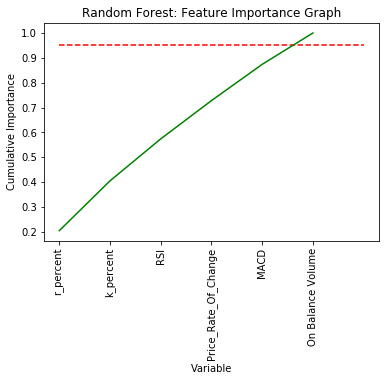

In [26]:
# store the values in a list to plot.
x_values = list(range(len(rand_frst_clf.feature_importances_)))

# Cumulative importances
cumulative_importances = np.cumsum(feature_imp.values)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin = 0, xmax = len(feature_imp), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, feature_imp.index, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Random Forest: Feature Importance Graph')

In [28]:
print('Random Forest Out-Of-Bag Error Score: {}'.format(rand_frst_clf.oob_score_))


Random Forest Out-Of-Bag Error Score: 0.6551155115511551
